# Reproduce the Laplace-approximated NAM
## References
```  
@misc{bouchiat2023laplaceapproximated,
      title={Laplace-Approximated Neural Additive Models: Improving Interpretability with Bayesian Inference}, 
      author={Kouroche Bouchiat and Alexander Immer and Hugo Yèche and Gunnar Rätsch and Vincent Fortuin},
      year={2023},
      eprint={2305.16905},
      archivePrefix={arXiv},
      primaryClass={stat.ML}
}
```

In [1]:
import time 
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib.pyplot as plt 
import numpy as np

from LANAM.models import LaNAM, BayesianLinearRegression

from LANAM.config.default import defaults

from LANAM.trainer.training import *
from LANAM.trainer.marglik_training import *
from LANAM.trainer.feature_interaction_selection import *

from LANAM.data.generator import *
from LANAM.data.toydataset import ToyDataset, ConcurvityDataset

from LANAM.utils.plotting import * 
from LANAM.utils.output_filter import OutputFilter


from laplace import Laplace
from laplace import marglik_training as lamt
from laplace.curvature.backpack import BackPackGGN
"""
Reference:
@misc{kayid2020nams,
  title={Neural additive models Library},
  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},
  year={2020}
}
"""

'\nReference:\n@misc{kayid2020nams,\n  title={Neural additive models Library},\n  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},\n  year={2020}\n}\n'

In [2]:
%reload_ext autoreload
%autoreload 2

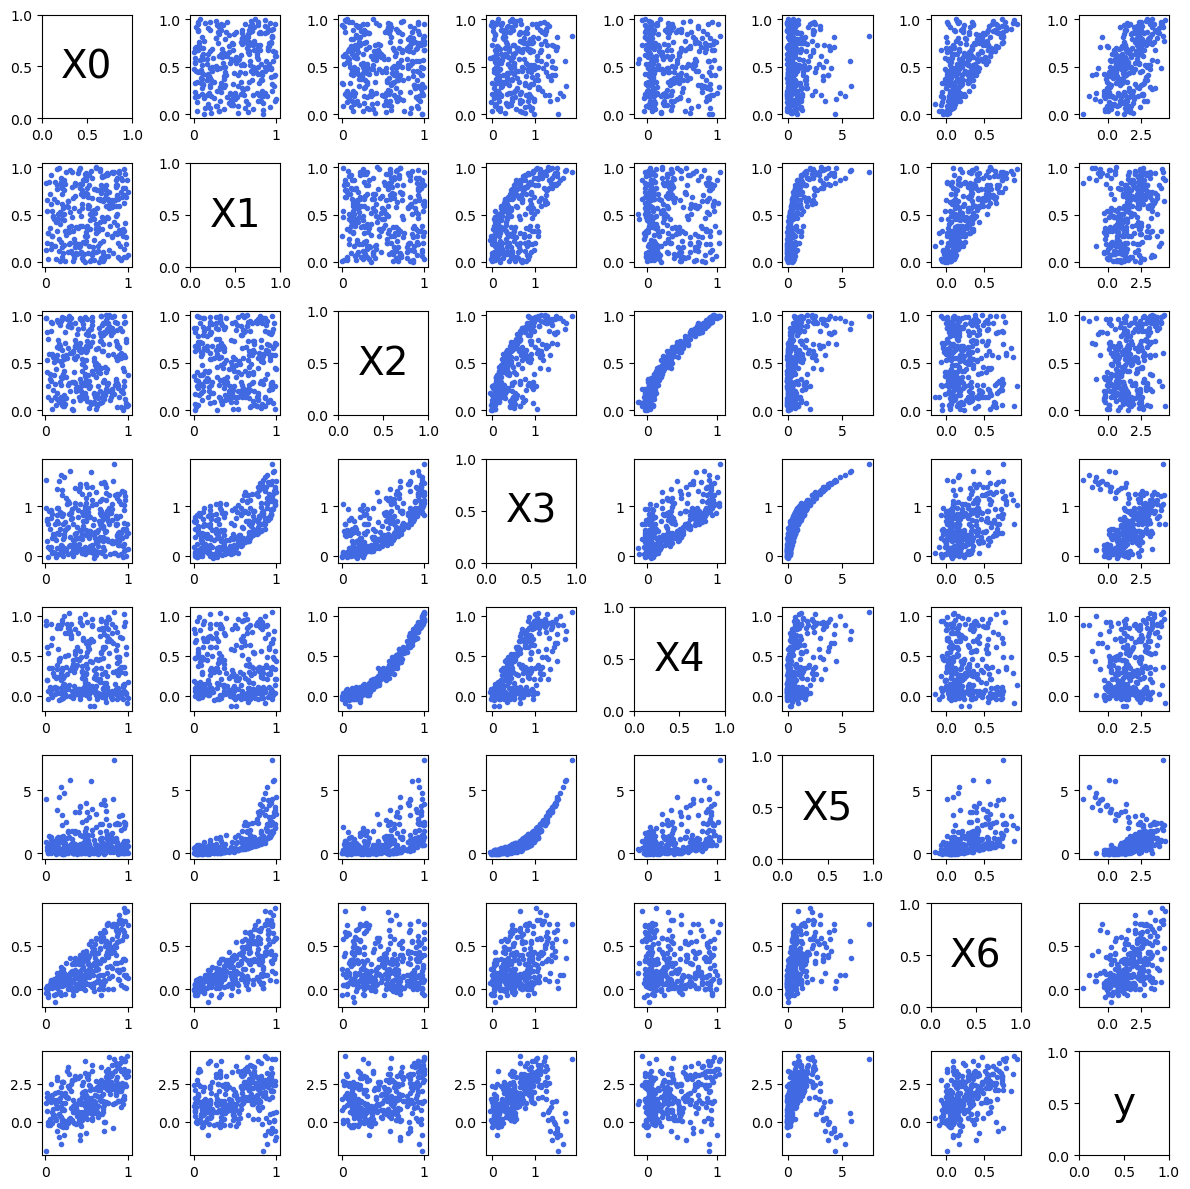

In [3]:
#cfg = defaults()
#gen_funcs, gen_func_names = task()
#in_features = len(gen_funcs)
#sigma = 0.3
#toy_trainset = ToyDataset(gen_funcs, gen_func_names,  num_samples=1000, sigma=sigma)
trainset = ConcurvityDataset(num_samples=700)
testset = ConcurvityDataset(num_samples=300)
in_features = trainset.X.shape[1]
cfg = defaults()
testset.plot()

In [7]:
fullm = LaNAM(config=cfg, name="LaNAM", in_features=in_features, hessian_structure='full', subset_of_weights='all')

start = time.time()
fullm, fullmargs, fulllosses, fullperfs = marglik_training(fullm, trainset.loader, trainset.loader_fnn, 'regression', 
                                                           use_wandb=False, testset=testset, optimizer_kwargs={'lr': 1e-2}, plot_kwargs={'plot_additive': False, 'plot_individual': False})
end = time.time()
print(f'Training time: {end-start:.3f}s')

[Epoch=100, n_hypersteps=29]: prior precision: [0.2890353  1.4266822  2.0660038  3.9165611  1.2101513  0.17146417
 2.4037423 ], sigma noise: [0.19234002 0.18697806 0.18634015 0.18660197 0.1893083  0.20820366
 0.18447949]
677.6288452148438
Predictive posterior std mean: 0.5060229897499084
[Epoch=200, n_hypersteps=29]: prior precision: [0.28969225 1.2577747  2.2957807  2.610295   1.0247251  0.13704051
 3.9546359 ], sigma noise: [0.19184713 0.17888102 0.17626645 0.18127874 0.18403517 0.22912988
 0.17175734]
618.6890869140625
Predictive posterior std mean: 0.500119149684906
[Epoch=300, n_hypersteps=29]: prior precision: [ 0.2997252  1.5911074  3.3599377  2.1120954  0.9277395  0.141299
 13.675577 ], sigma noise: [0.19880076 0.17369178 0.16821404 0.18415478 0.18445647 0.27303833
 0.15929222]
621.2217407226562
Predictive posterior std mean: 0.5173618197441101
[Epoch=400, n_hypersteps=29]: prior precision: [  0.30177528   2.3941712    5.2115107    1.7611192    0.855407
   0.13955967 117.80993 

In [8]:
print(f"Sigma noise: {fullm.sigma_noise.detach().numpy()}")
print(f"Prior precision: {fullm.prior_precision.detach().numpy()}")
print(f"Additive sigma noise: {fullm.additive_sigma_noise}")

Sigma noise: [0.20111258 0.16405259 0.15790395 0.18578327 0.18200527 0.29823616
 0.14219072]
Prior precision: [  0.30177528   2.3941712    5.2115107    1.7611192    0.855407
   0.13955967 117.80993   ]
Additive sigma noise: 0.5187461376190186


In [9]:
k_pairs, sorted_mis = feature_interaction_selection(fullm, trainset.loader)

/home/zhangx18/.local/lib/python3.10/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class 'LANAM.utils.output_filter.OutputFilter'> although the module has parameters
  warnings.warn(
/home/zhangx18/.local/lib/python3.10/site-packages/backpack/extensions/backprop_extension.py:106: UserWarning: Extension saving to grad_batch does not have an extension for Module <class 'LANAM.models.featurenn.FeatureNN'> although the module has parameters
  warnings.warn(


In [10]:
print(k_pairs)
print(sorted_mis)

[(0, 5), (4, 5), (3, 5), (0, 4), (1, 5)]
{(0, 5): 292.3323287963867, (4, 5): 226.02877521514893, (3, 5): 154.36173629760742, (0, 4): 129.7505965232849, (1, 5): 124.96670150756836, (0, 3): 61.304561614990234, (2, 5): 49.95851707458496, (0, 1): 18.194632530212402, (3, 4): -30.963330268859863, (0, 2): -40.54537105560303, (1, 4): -60.699416160583496, (1, 3): -131.52006006240845, (2, 4): -137.02967643737793, (2, 3): -207.01766967773438, (1, 2): -236.80388641357422, (5, 6): -251.73838424682617, (0, 6): -339.17704486846924, (4, 6): -437.8418231010437, (3, 6): -508.49244499206543, (1, 6): -538.6699123382568, (2, 6): -613.9461708068848}


In [ ]:
cfg.activation_cls = 'relu'
kronm = LaNAM(config=cfg, name="LaNAM", in_features=in_features, hessian_structure='kron', subset_of_weights='all')
print(kronm)
start = time.time()
kronm, kronmargs, kronlosses, kronperfs = marglik_training(
    kronm, trainset.loader, trainset.loader_fnn, 'regression', testset=testset, n_epochs=20,
    n_epochs_burnin=0, n_hypersteps=30, marglik_frequency = 5,
    use_wandb=False, optimizer_kwargs={'lr': 1e-2})
end = time.time()

print(f'Training time: {end-start:.3f}s')

print(f"Sigma noise: {kronm.sigma_noise.detach().numpy()}")
print(f"Prior precision: {kronm.prior_precision.detach().numpy()}")
print(f"Additive sigma noise: {kronm.additive_sigma_noise}")

In [ ]:
from laplace import marglik_training as mt
def get_model():
    return nn.Sequential(
        nn.Linear(1, 64),
        nn.ReLU(), 
        nn.Linear(64, 1)
    )
    
model = get_model()
la, model, margliks, losses = mt(
    model=model, train_loader=trainset.loader, likelihood='regression',
    hessian_structure='kron', backend=BackPackGGN, n_epochs=200, 
    optimizer_kwargs={'lr': 1e-2}, prior_structure='scalar'
)
f_mu, f_var = la(testset.X)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)
print(la.sigma_noise, la.prior_precision)
fig_addi, axs = plt. subplots()
axs.plot(testset.X[:, 0], testset.y, '--', label="targeted", color="gray")
axs.plot(testset.X[:, 0], f_mu, '-', label="prediction", color="royalblue")
axs.fill_between(testset.X[:, 0].flatten(), f_mu-2*pred_std, f_mu+2*pred_std, alpha=0.2)